In [1]:
from omegaconf import OmegaConf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from interactive_coloring.regionSelecter import RandomRegionSelecter
from interactive_coloring.segmenter import SimpleSegmenter
from interactive_coloring.colorizer import ControlNetColorizer
from interactive_coloring.processing import preprocess_lineart

In [2]:
config = OmegaConf.load('models/interactivce-coloring.yaml')

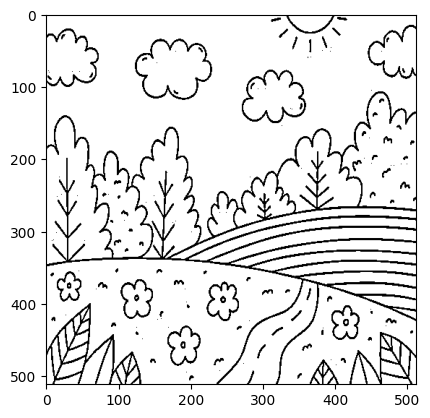

In [3]:
img = cv2.imread('./assets/lineart0.jpg')
img = cv2.resize(img, (512, 512))
map_color = np.zeros_like(img)
lineart = preprocess_lineart(img)

plt.imshow(lineart, cmap='gray')

### [Segmenter]: Interacive 컬러링을 위해 line art의 영역 분할

In [4]:
# opencv를 사용한 간단한 Segmenter 클래스
segmenter = SimpleSegmenter()

n_labels:  73


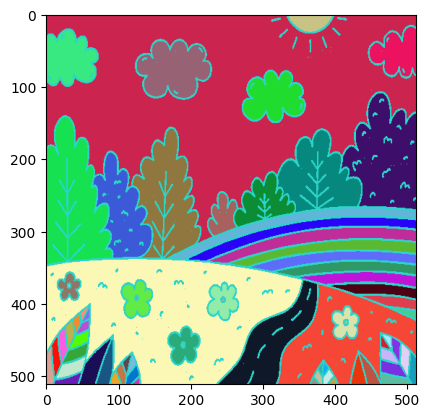

In [5]:
# lineart의 각 영역을 분할, 라벨링
n_labels, map = segmenter(lineart)

# segmentation map 확인을 위해 각 라벨마다 랜덤 컬러를 부여
for i in range(n_labels):
    map_color[map==i] = [int(j) for j in np.random.randint(0,255,3)]

print("n_labels: ", n_labels)
plt.imshow(map_color)

### [RegionSelecter]: 다음 컬러링할 영역을 선택

In [6]:
# Uncolored region 중 하나를 랜덤으로 골라 target으로 결정하는 클래스
regionSelecter = RandomRegionSelecter()

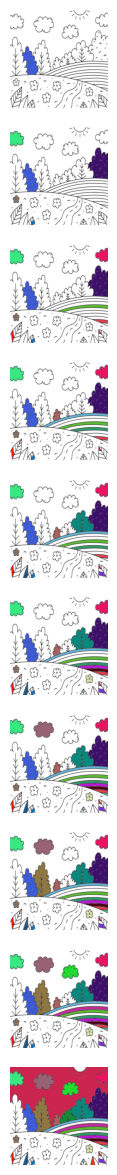

In [7]:
# 순차척 컬러링 테스트해보기
# segmentation 이후 각 영역을 차례로 색칠해나가는 과정 확인(컬러는 랜덤, 컬러링 모델은 아직 적용 X)
n = 50
fig, axes = plt.subplots(10, 1)
fig.set_size_inches(20, 15)

for i in range(n):
    # 매 iter마다 uncolored region 중 한 영역을 정해 target mask 생성
    target_mask = regionSelecter.decide_next(img, map)
    # Target mask에 해당하는 부분만 coloring
    img[target_mask>0.5] = map_color[target_mask>0.5]
    # 시각화
    if i % 5 == 0:
        axes[i//5].axis('off')
        axes[i//5].imshow(img)
        cv2.imwrite('img.png', img)

### [Colorizer]: Target mask를 색칠

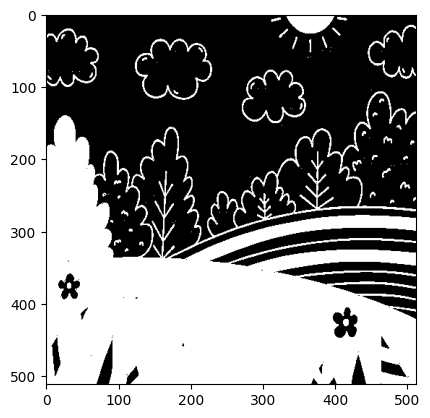

In [8]:
color_mask = regionSelecter.get_color_mask(img)
plt.imshow(color_mask, cmap='gray')

In [9]:

colorizer = ControlNetColorizer(ldm_checkpoint='./models/anything-v3-full.safetensors',
                                cldm_checkpoint='./models/control_v11p_sd15s2_lineart_anime.pth',
                                **config.colorizer.params)

/hdd1/aidml/sjwi/interactive-colorization/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

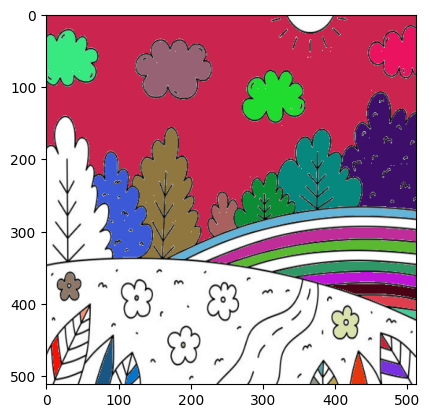

In [10]:
from interactive_coloring.utils import HWC3
img = cv2.resize(img, (512,512))
img = HWC3(img)
plt.imshow(img)

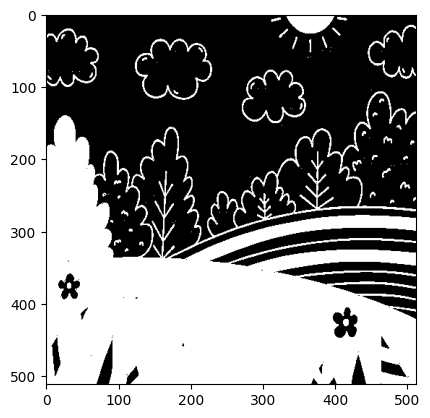

In [11]:
color_mask = regionSelecter.get_color_mask(img)
plt.imshow(color_mask, cmap='gray')

In [17]:
output = colorizer.colorize_target(img, color_mask, 20, color_mask)
output[0] = output[0].astype(np.uint8)

Selected timesteps for ddim sampler: [  1  51 101 151 201 251 301 351 401 451 501 551 601 651 701 751 801 851
 901 951]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9505, 0.8930, 0.8264, 0.7521, 0.6722, 0.5888, 0.5048, 0.4229,
        0.3456, 0.2750, 0.2128, 0.1598, 0.1163, 0.0819, 0.0557, 0.0365, 0.0231,
        0.0140, 0.0082]); a_(t-1): [0.99914998 0.99829602 0.95052433 0.89298052 0.82639927 0.75214338
 0.67215145 0.58881873 0.50481856 0.42288151 0.34555823 0.27499905
 0.21278252 0.15981644 0.11632485 0.08191671 0.05571903 0.03654652
 0.02307699 0.0140049 ]
For the chosen value of eta, which is 1.0, this results in the following sigma_t schedule for ddim sampler tensor([0.0206, 0.0406, 0.1673, 0.2144, 0.2509, 0.2836, 0.3144, 0.3442, 0.3732,
        0.4016, 0.4293, 0.4565, 0.4829, 0.5087, 0.5336, 0.5576, 0.5807, 0.6029,
        0.6241, 0.6444], dtype=torch.float64)
Data shape for DDIM sampling is (1, 4, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


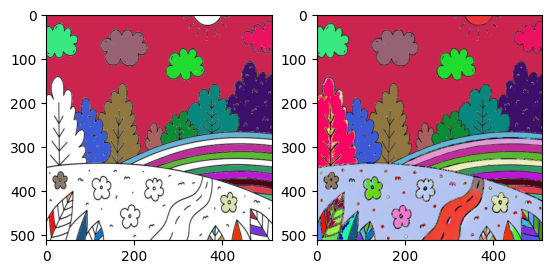

In [21]:
fig, axes =  plt.subplots(1,2)
axes[0].imshow(img)
axes[1].imshow(output[0])